Ch.3 word2vec

이 장에서는 '추론 기반 기법'을 살펴 본다. 
단순한 word2vec을 구현하여 이해하고자 한다.

통계 기반의 문제점 => 거대 행렬에 SVD기법을 적용하는 것은 현실적이지 않다.(비용 O(n^3))

반면 추론 기반의 기법은 미니 배치 학습을 사용할 수 있기 때문에 병렬계산도 가능해서 학습 속도가 빠름.

추론 기반 기법이란?

주변 단어(맥락)가 주어졌을 때 ?의 단어를 추측하는 작업

input : 주변단어
output : 추측 단어

신경망에서의 단어 처리

단어 => 고정 길이의 벡터(원핫 벡터)

벡터 변환 방법

1. 벡터의 차원 : 총 어휘의 수 

2. if 인덱스 == 단어 ID : 1
else : 0

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[ 0.32624958 -1.58554966  0.90270204]]


위 코드는 벡터를 원 핫벡터로 변환한 뒤 fully-connected layer를 이용하여 다시 변환 시켜주는 코드임.

c의 차원 수는 2 (미니배치를 고려한 것)

c와 W의 행렬곱은 c가 원핫벡터이므로 가중치의 행벡터를 하나 추출한 것과 같다.

1장에서 구현한 MatMul계층에서 구현하려면 아래와 같다.

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

ModuleNotFoundError: ignored

단순한 word2vec => CBOW모델

목적 : 추론을 활용하여 단어의 분산표현을 얻는 것

입력층이 여러개이면 입력층에 의해 변환된 값을 '평균'을 구해서 변환 시킴.

ex)h_1와 h_2가 입력층에 의해 변환 되었다면 (h_1+h_2)/2를 구해서 출력층으로 보내주면 된다.

입력층의 가중치가 바로 단어으 분산표현의 핵심이다.

은닉층의 뉴런수는 입력층보다 적게 해야 밀집벡터가 완성됨.=> 인코딩

출력층에서는 각 단어의 '점수'를 출력함. 여기에 softmax를 적용하면 확률을 얻을 수 있음.

In [3]:
import numpy as np

c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

#W_in을 공유함에 주의
h_1 = np.matmul(c0, W_in)
h_2 = np.matmul(c1, W_in)
h = 0.5 * (h_1 + h_2)
s = np.matmul(h, W_out)

print(s)

[[ 0.12881663  0.79031782 -0.58606968  0.10820439  1.43804941  0.83428569
  -2.45277561]]


결과적으로 W_in과 W_out 모두에 단어의 출현벡터를 파악한 벡터가 학습됨.

softmax with loss 계층을 사용하여 학습을 진행

W_in의 각 행이 각 단어의 분산 표현에 해당된다면 W_out의 각 열은 단어의 분산표현이라고 할 수 있다.

W_in만을 분산표현으로 사용하는 것이 일반적이지만 Glove에서는 두 가중치를 더해서 사용하는 것이 좋은 결과를 얻음.

In [4]:
def preprocess(text) :
  text= text.lower()
  text = text.replace('.',' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}
  for word in words :
    if word not in word_to_id :
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])
  
  return corpus, word_to_id, id_to_word

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [8]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [9]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [10]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW
        
        return dx

In [11]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [12]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # Convert to correct label index if input data is one-hot-vector
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [13]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)

        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [14]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [15]:
import time

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # Finding gradients and updating parameters
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [16]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [17]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # weight initialization
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # the preparation of a layer
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # List all weights and gradients
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # Set word distribution expression in member variables
        self.word_vecs = W_in
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

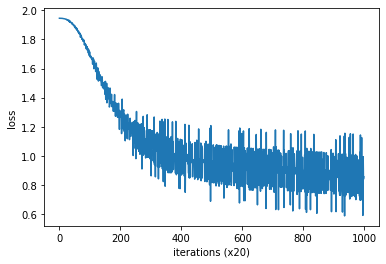

you [ 1.1697924  1.1884756 -1.1436954 -1.1503748  1.1866586]
say [-1.1892817 -1.1902381  1.1228154  1.198114  -1.1660086]
goodbye [ 0.74630207  0.7778211  -0.81404203 -0.78010535  0.6750232 ]
and [-0.99551904 -0.9412282   1.2830328   1.0362003  -1.3110992 ]
i [ 0.7853035   0.7885493  -0.8151438  -0.7644631   0.63009936]
hello [ 1.1550705  1.2062888 -1.164045  -1.1648403  1.2154895]
. [-1.0717089  -1.1197091   0.30512652  0.9829607  -0.30143386]


In [18]:
import matplotlib.pyplot as plt

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()
plt.show()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

3.5.1 CBOW모델과 확률

L=-logP(w_t|w_(t-1),w_(t+1))

음의 로그 가능도 => 교차 크로스 엔트로피

skip-gram의 경우 L값을 구할 때 동시발생 확률이므로 확률을 곱하지만 로그를 씌워주면 더하기로 변해서 2개의 단어의 조건부확률을 더해주는 식으로 변한다. 

말뭉치가 커질 수록 skip-gram모델이 더 뛰어난 경향이 있다. 


word2vec는 가중치를 다시 학습 시킬 수 있어서 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수핼할 수 있음.